#CAD PROJECT

Baseline model based on:
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks


Made by MAIA team: Jaime, Ahmed & "Prem"

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* In **finetuning**, we start with a pretrained model and update *all* of the model’s parameters for our new task, in essence retraining the whole model.
* In **feature extraction** we start with a pretrained model and only update the final layer weights from which we derive predictions. It is called feature extraction because we use the pretrained CNN as a fixed feature-extractor, and only change the output layer.

In general both transfer learning methods follow the same few steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step




In [0]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
import sys
import os
import copy
%matplotlib inline

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

!pip install barbar

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


In [0]:
path_folder='/content/drive/My Drive/Colab Notebooks/CAD Project/'
sys.path.insert(1, path_folder) # Import py files in the folder

Initialize the Inputs
------


The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




In [0]:
###### SELECT CHALLANGE TYPE ##########

CHALLANGE_TYPE = {
    1: "Dermo Challenge",
    2: "Histopathology Challenge",
}
CHALLANGE_TYPE_INDEX = 1;

CHALLANGE_TYPE_STR =CHALLANGE_TYPE.get(CHALLANGE_TYPE_INDEX, "Invalid normalization type")
print(CHALLANGE_TYPE_STR)

###### CHANGE THIS PARAMETERS ###########
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, resnext50]
MODEL_NAME = "densenet"

# EXPERIMENT NAMES
EXPERIMENT_NAME='Augmentation'  #Write the folder name of the expriment
SUB_EXPERIMENT_NAME = MODEL_NAME

# Batch size for training (change depending on how much memory you have)
BATCH_SIZE = 16

# Number of epochs to train for 
NUM_EPOCHS = 30


PREPROCESS_DATA = True  #Only for Dermo

AUGMENTATION_ENABLE = True

if(CHALLANGE_TYPE_INDEX == 1):
  INPUT_SIZE=225


if(CHALLANGE_TYPE_INDEX == 2):
  INPUT_SIZE=96

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
FEATURE_EXTRACT= False #If False: Unfreeze the Network layers
USE_PRETRAINED = True #Use the ImageNet pretrained weights


###### CHANGE THIS PARAMETERS ###########



Dermo Challenge


In [0]:
options = {}
options['train_split']  = 0.2
options["input_size"]=INPUT_SIZE
options["challenge_dir"]=os.path.join(path_folder,CHALLANGE_TYPE_STR+"/")
if(PREPROCESS_DATA):
  options["train_dir"]=os.path.join(options["challenge_dir"],"train_pre2/")
  options["val_dir"]=os.path.join(options["challenge_dir"],"val_pre2/")
  options["test_dir"]=os.path.join(options["challenge_dir"],"test_pre2/")
else:
  options["train_dir"]=os.path.join(options["challenge_dir"],"train/")
  options["val_dir"]=os.path.join(options["challenge_dir"],"val/")
  options["test_dir"]=os.path.join(options["challenge_dir"],"test/")
  options["train_val_dir"]=os.path.join(options["challenge_dir"],"val_pt1/")
  options["val_dir"]=os.path.join(options["challenge_dir"],"val_pt2/")
if(CHALLANGE_TYPE_INDEX == 1):
  options["experiments_dir"]=os.path.join(path_folder,"Dermo_Experiments2")
if(CHALLANGE_TYPE_INDEX == 2):
  options["experiments_dir"]=os.path.join(path_folder,"Histo_Experiments2")
options["models_dir"]=os.path.join(options["experiments_dir"],EXPERIMENT_NAME)
options["batch_size"]=BATCH_SIZE

# Number of classes in the dataset
num_classes = 2

In [0]:
print(options["train_dir"])
print(options["val_dir"])

/content/drive/My Drive/Colab Notebooks/CAD Project/Dermo Challenge/train_pre2/
/content/drive/My Drive/Colab Notebooks/CAD Project/Dermo Challenge/val_pre2/


Initialize and Reshape the Networks
-----------------------------------



In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
import sys
import os
import copy

def set_parameter_requires_grad(model, feature_extracting):
    """
     
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting. By
    default, when we load a pretrained model all of the parameters have
    ``.requires_grad=True``, which is fine if we are training from scratch
    or finetuning. However, if we are feature extracting and only want to
    compute gradients for the newly initialized layer then we want all of
    the other parameters to not require gradients. This will make more sense
    later.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

In [0]:
from MAIA_model import initialize_model
# Initialize the model for this run
model_ft = initialize_model(MODEL_NAME, num_classes, FEATURE_EXTRACT, use_pretrained=USE_PRETRAINED)

# Print the model we just instantiated
print(model_ft)

model_ft.to('cuda')

from torchsummary import summary
summary(model_ft, (3,INPUT_SIZE, INPUT_SIZE))

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [0]:
from MAIA_Loader import get_train_valid_loader_AUG, get_val_loader,get_train_loader_AUG

if CHALLANGE_TYPE_INDEX==2:
  training=get_train_loader_AUG(data_dir=options["train_dir"],batch_size= options["batch_size"],augment=AUGMENTATION_ENABLE, input_size= options["input_size"],challenge_type=CHALLANGE_TYPE_INDEX)
  training_val=get_val_loader(data_dir=options["train_val_dir"],batch_size=options["batch_size"],input_size=options["input_size"])
  data_loader_validation=get_val_loader(data_dir=options["val_dir"],batch_size=options["batch_size"],input_size=options["input_size"])

  dataloaders_dict_train={"train":training,
                        "val":training_val}

else:
  dataloaders_dict_train=get_train_valid_loader_AUG(data_dir=options["train_dir"],batch_size= options["batch_size"],augment=AUGMENTATION_ENABLE, input_size= options["input_size"],valid_size=options['train_split'],challenge_type = CHALLANGE_TYPE_INDEX)
  data_loader_validation=get_val_loader(data_dir=options["val_dir"],batch_size=options["batch_size"],input_size=options["input_size"])


Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the ADAM algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [0]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if FEATURE_EXTRACT:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

Train the model
--------------------------------

The next step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [0]:
from barbar import Bar

def train_model(device, model, dataloaders, criterion, optimizer, num_epochs, save_model_path, is_inception=False):
    """
    The ``train_model`` function handles the training and validation of a
    given model. As input, it takes a PyTorch model, a dictionary of
    dataloaders, a loss function, an optimizer, a specified number of epochs
    to train and validate for, and a boolean flag for when the model is an
    Inception model. The *is_inception* flag is used to accomodate the
    *Inception v3* model, as that architecture uses an auxiliary output and
    the overall model loss respects both the auxiliary output and the final
    output, as described
    `here <https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958>`__.
    The function trains for the specified number of epochs and after each
    epoch runs a full validation step. It also keeps track of the best
    performing model (in terms of validation accuracy), and at the end of
    training returns the best performing model. After each epoch, the
    training and validation accuracies are printed.
    """
    since = time.time()

    training_metrics=np.zeros((num_epochs,4))
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total_len=0
            # Iterate over data.
            for inputs, labels in Bar(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    total_len+=len(preds)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / total_len
            epoch_acc = running_corrects.double() / total_len

            print()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch=epoch
            # Save metrics
            if phase == 'train':
                training_metrics[epoch,[0,1]]=[epoch_loss, epoch_acc]
                torch.save(model.state_dict(), os.path.join(save_model_path + "_"+str(epoch) + '.pt'))
            else:
                training_metrics[epoch,[2,3]]=[epoch_loss, epoch_acc]
            # Save model

        print()

    fig=plt.figure(figsize=(20, 5))
    fig.add_subplot(1, 2, 1)
    plt.plot(training_metrics[:,[0,2]])
    plt.legend(["training","validation_training"])
    plt.title('Training Loss') 
    fig.add_subplot(1, 2, 2)
    plt.plot(training_metrics[:,[1,3]])
    plt.legend(["training","validation_training"])
    plt.title('Training Accuracy') 
    plt.show()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_metrics,best_epoch




def evaluate_model(device,model, dataloaders, is_inception=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    total_len=0
    # Iterate over data.
    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            #   mode we calculate the loss by summing the final output and the auxiliary output
            #   but in testing we only consider the final output.
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total_len+=len(preds)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    epoch_acc = running_corrects.double() / total_len

    print(' Acc: {:.4f}'.format( epoch_acc))

    print()

    time_elapsed = time.time() - since
    print('Evaluation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    

    # load best model weights
    return epoch_acc.cpu().numpy()

Epoch 1/30
----------
3840/4800: [===============================>] - ETA 4.4s
train Loss: 0.5051 Acc: 0.7508
 960/4800: [===============================>] - ETA 5.1s
val Loss: 0.4815 Acc: 0.7635

Epoch 2/30
----------
3840/4800: [===============================>] - ETA 1.2s
train Loss: 0.4779 Acc: 0.7734
 960/4800: [===============================>] - ETA 0.9s
val Loss: 0.4649 Acc: 0.7844

Epoch 3/30
----------
3840/4800: [===============================>] - ETA 1.0s
train Loss: 0.4425 Acc: 0.7932
 960/4800: [===============================>] - ETA 0.8s
val Loss: 0.4099 Acc: 0.7937

Epoch 4/30
----------
3840/4800: [===============================>] - ETA 1.2s
train Loss: 0.4166 Acc: 0.8034
 960/4800: [===============================>] - ETA 0.7s
val Loss: 0.4496 Acc: 0.7865

Epoch 5/30
----------
3840/4800: [===============================>] - ETA 1.2s
train Loss: 0.4069 Acc: 0.8130
 960/4800: [===============================>] - ETA 0.7s
val Loss: 0.3712 Acc: 0.8146

Epoch 6/30
----

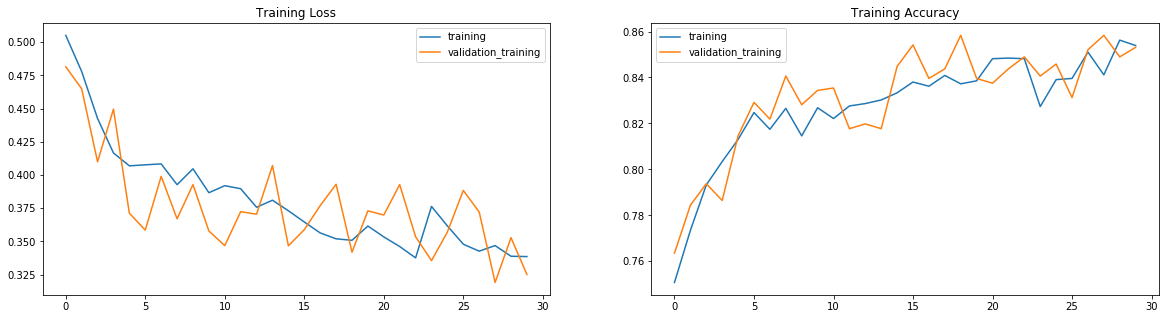

Training complete in 40m 30s
Best val Acc: 0.858333


,count,mean,std,min,25%,50%,75%,max
train_loss,30.0,0.381187,0.040488,0.337606,0.351121,0.374386,0.401660,0.505074
train_acc,30.0,0.827665,0.023150,0.750781,0.822786,0.831771,0.840560,0.856250
val_loss,30.0,0.376851,0.037573,0.319121,0.354408,0.370845,0.392749,0.481469
val_acc,30.0,0.830937,0.023260,0.763542,0.820312,0.838542,0.845573,0.858333


In [0]:

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

if not os.path.isdir(options["models_dir"]):
        print("Creating Experiment Folder")
        os.mkdir(options["models_dir"])

save_model_path= os.path.join(options['models_dir'], SUB_EXPERIMENT_NAME )

# Train the model
try:
  model_ft, training_metrics,best_epoch = train_model(device, model_ft,  dataloaders_dict_train, criterion, optimizer_ft, num_epochs=NUM_EPOCHS,save_model_path=save_model_path,is_inception=(MODEL_NAME=="inception"))
except KeyboardInterrupt:
    pass

# Save results
df_training = pd.DataFrame(training_metrics, columns=["train_loss","train_acc","val_loss"," val_acc"],index=list(range(1,NUM_EPOCHS+1)))
df_training.to_excel(options["models_dir"]+'/'+MODEL_NAME+".xlsx")
df_training.describe().T

Evaluate the model
------
In the following code, the model cand be selected manually or automatically from the best model. Then validation set accuracy is calculated from the pridected output.

In [0]:
SELECT_MODEL_MANUALLY=False

if(SELECT_MODEL_MANUALLY):
  selected_epoch=1
  model_ft.load_state_dict(torch.load(save_model_path + "_"+str(selected_epoch) + '.pt'))
else:
  selected_epoch=best_epoch

In [0]:
from MAIA_model import evaluate_model

# Evaluation of the model
try:
  evaluation_metrics=evaluate_model(device, model_ft,data_loader_validation, is_inception=(MODEL_NAME=="inception"))
except KeyboardInterrupt:
    pass

df_columns=["Acc","Epoch","Model","Feature_extraction","Input","Batch"]
df_values=[(evaluation_metrics,selected_epoch,MODEL_NAME,FEATURE_EXTRACT,INPUT_SIZE,BATCH_SIZE)]

df_evaluation = pd.DataFrame(df_values, columns=df_columns, index=[SUB_EXPERIMENT_NAME])

if os.path.isfile(options["experiments_dir"]+"/"+EXPERIMENT_NAME+".xlsx"):
  df_original=pd.read_excel(options["experiments_dir"]+"/"+EXPERIMENT_NAME+".xlsx", index_col=0)
  df_original=df_original.append(df_evaluation,sort=False)
  df_original.to_excel(options["experiments_dir"]+"/"+EXPERIMENT_NAME+".xlsx")
else:
  df_evaluation.to_excel(options["experiments_dir"]+"/"+EXPERIMENT_NAME+".xlsx")

 Acc: 0.8458

Evaluation complete in 1m 37s
